# Filtered navigable network

This notebook test the way to create nodes and edges compatibles with OSMnx in order to be able to __use Santiago's public space quality index__ (Available in non-OSMnx road linestrings) __as a filter.__

__The results were incorporated into Script 27-compiler_hqsl.py__

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [4]:
grl_dir = "../../../data/external/santiago/calidad_ep/"

# __Temporal QGIS Solution__

In [18]:
network_edges = gpd.read_file(grl_dir + 'red_buena_calidad_single_parts.gpkg')
network_edges = network_edges.set_crs("EPSG:32719")

# Show
print(network_edges.shape)
network_edges.head(1)

(15771, 3)


,Nom_Rut,pje_ep,geometry
0,Costanera Sur,0.549756,"LINESTRING (350915.673 6302582.007, 350910.519..."


In [19]:
network_nodes = gpd.read_file(grl_dir + 'red_buena_calidad_nodes.shp')
network_nodes = network_nodes.set_crs("EPSG:32719")

# Show
print(network_nodes.shape)
network_nodes.head(1)

(14543, 10)


,fid,Nom_Rut,pje_ep,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,Costanera Sur,0.549756,0,0,0,0,0.0,191.098679,POINT (350915.673 6302582.007)


In [31]:
nodes, edges = aup.create_network(network_nodes, network_edges,"EPSG:32719")
nodes = nodes.drop_duplicates(subset=['osmid'])

In [32]:
# Show
print(nodes.shape)
nodes.head(1)

(14537, 11)


,fid,Nom_Rut,pje_ep,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry,osmid
0,1.0,Costanera Sur,0.549756,0,0,0,0,0.0,191.098679,POINT (-70.60322 -33.40575),3509156302582


In [22]:
# Show
print(edges.shape)
edges.head(1)

(15771, 7)


,Nom_Rut,pje_ep,geometry,u,v,key,length
0,Costanera Sur,0.549756,"LINESTRING (-70.60322 -33.40575, -70.60328 -33...",3509156302582,3509786302390,0,229.719497


In [23]:
edges_filt = edges.loc[edges.pje_ep >= 0.5]

# Show
print(edges_filt.shape)
edges_filt.head(1)

(15771, 7)


,Nom_Rut,pje_ep,geometry,u,v,key,length
0,Costanera Sur,0.549756,"LINESTRING (-70.60322 -33.40575, -70.60328 -33...",3509156302582,3509786302390,0,229.719497


<Axes: >

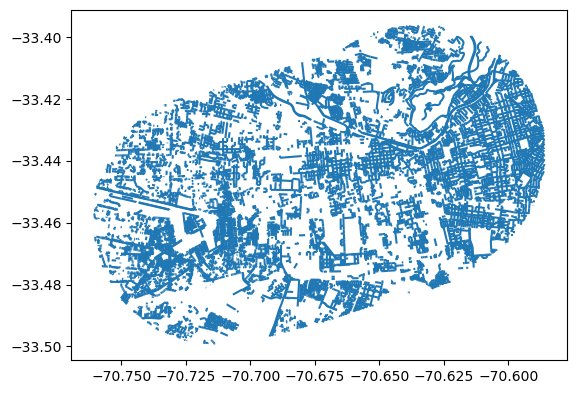

In [24]:
edges_filt.plot()

In [25]:
import osmnx as ox

nodes_gdf = nodes.copy()
nodes_gdf.set_index('osmid',inplace=True)

edges_gdf = edges_filt.copy()
edges_gdf.set_index(['u','v','key'],inplace=True)

nodes_gdf['x'] = nodes_gdf['geometry'].x
nodes_gdf['y'] = nodes_gdf['geometry'].y

G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)
G

# __Optimal solution (WIP)__

## Load ep network data

In [ ]:
network = gpd.read_file(grl_dir + 'red_buena_calidad.gpkg')
network = network.set_crs("EPSG:32719")

# Show
print(network.shape)
network.head(1)

## Extract vertices

In [6]:
gdf = network[['pje_ep','geometry']].copy()
gdf = gdf.to_crs("EPSG:4326")

# Explode multi-part geometries into single parts
gdf_exploded = gdf.explode(index_parts=False)

# Reset index
gdf_exploded.reset_index(inplace=True)
gdf_exploded.drop(columns=['index'],inplace=True)

#Initialize an empty list to store the points
points = []
attributes = []

#Iterate through each LineString and extract its vertices
for idx, row in gdf_exploded.iterrows():
    line = row.geometry
    for coord in line.coords:
        points.append(Point(coord))
        attributes.append(row.pje_ep)

# Create a new GeoDataFrame from the points
gdf_points = gpd.GeoDataFrame(attributes,geometry=points)

# Rename data
gdf_points.rename(columns={0:'pje_ep'},inplace=True)

# Show
print(gdf_points.shape)
gdf_points.head(1)

(95880, 2)


,pje_ep,geometry
0,0.209171,POINT (-70.60280 -33.40858)


## Create nodes and edges compatible with OSMnx

In [7]:
edges = gdf_exploded.copy()
edges = edges.set_crs("EPSG:4326")

nodes = gdf_points.copy()
nodes = nodes.set_crs("EPSG:4326")

nodes, edges = aup.create_network(nodes, edges,"EPSG:32719")

In [8]:
# Show
print(nodes.shape)
nodes.head(1)

(95880, 3)


,pje_ep,geometry,osmid
0,0.209171,POINT (-70.60280 -33.40858),3509586302268


In [9]:
# Show
print(edges.shape)
edges.head(1)

(31554, 6)


,pje_ep,geometry,u,v,key,length
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",3509586302268,3512566302306,0,300.673461


## Test filtering by pje_ep

In [10]:
edges_filt = edges.loc[edges.pje_ep >= 0.5]

# Show
print(edges_filt.shape)
edges_filt.head(1)

(15772, 6)


,pje_ep,geometry,u,v,key,length
6,0.549756,"LINESTRING (-70.60322 -33.40575, -70.60328 -33...",3509156302582,3509786302390,0,229.719497


<Axes: >

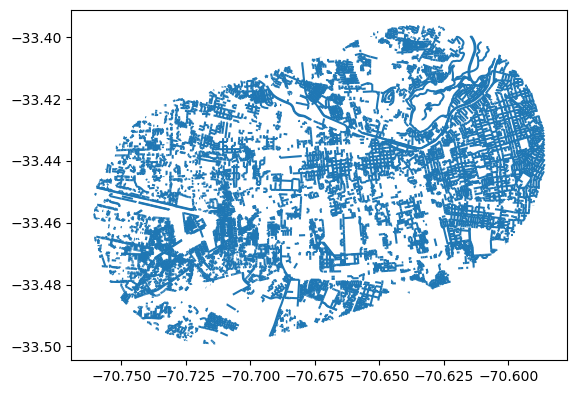

In [11]:
edges_filt.plot()

In [12]:
nodes.head(1)

,pje_ep,geometry,osmid
0,0.209171,POINT (-70.60280 -33.40858),3509586302268


## Testing create graph from those nodes and edges

In [15]:
import osmnx as ox

nodes_gdf = nodes.copy()
nodes_gdf.set_index('osmid',inplace=True)

edges_gdf = edges_filt.copy()
edges_gdf.set_index(['u','v','key'],inplace=True)

nodes_gdf['x'] = nodes_gdf['geometry'].x
nodes_gdf['y'] = nodes_gdf['geometry'].y

G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

In [16]:
G

## __Side job: Upload second alameda buffer to aois gdf__

In [34]:
buffer = gpd.read_file(grl_dir + 'nueva_alameda_buffer4500m_32719.gpkg')

buffer['city'] = 'alamedabuffer_4500m'
buffer = buffer[['city','geometry']]
buffer = buffer.to_crs("EPSG:4326")

# Show
print(buffer.crs)
print(buffer.shape)
buffer.head(1)

EPSG:4326
(1, 2)


,city,geometry
0,alamedabuffer_4500m,"MULTIPOLYGON (((-70.71802 -33.41807, -70.70348..."


In [35]:
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'

query = f"SELECT * FROM {aoi_schema}.{aoi_table}"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# Show
print(aoi.crs)
print(aoi.shape)
aoi.head(1)

EPSG:4326
(1, 2)


,city,geometry
0,AM_Santiago,"MULTIPOLYGON (((-70.69165 -33.80508, -70.69167..."


<Axes: >

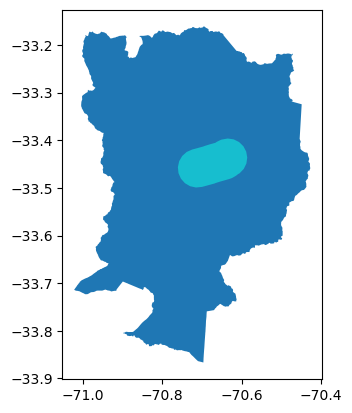

In [38]:
aoi.loc[1,'city'] = buffer.city.unique()[0]
aoi.loc[1,'geometry'] = buffer.geometry.unique()[0]

aoi.plot('city')

In [39]:
aoi

,city,geometry
0,AM_Santiago,"MULTIPOLYGON (((-70.69165 -33.80508, -70.69167..."
1,alamedabuffer_4500m,"MULTIPOLYGON (((-70.71802 -33.41807, -70.70348..."


In [41]:
save = False

save_schema = 'projects_research'
save_table = 'santiago_aoi'
if_exists = 'replace'

if save:
    aup.gdf_to_db_slow(aoi, save_table, save_schema, if_exists=if_exists)

# __Other code and tests__

### Option b

In [156]:
gdf = network.copy()
gdf = gdf.to_crs("EPSG:4326")

# Get vertices coordinates
gdf_coords = gdf.geometry.get_coordinates()

# Merge back with gdf containing data
gdf_coords_data = pd.merge(gdf_coords,gdf,left_index=True,right_index=True)

# Drop poly geometry 
df_coords_data = gdf_coords_data.drop(columns=['geometry'])

# Set points geometry
gdf_2 = gpd.GeoDataFrame(df_coords_data, 
                         geometry=gpd.points_from_xy(df_coords_data.x, df_coords_data.y),
                        crs='EPSG:4326')

gdf_2 = gdf_2[['pje_ep','geometry']]

# Show
print(gdf_2.shape)
gdf_2.head(1)

(95880, 2)


,pje_ep,geometry
0,0.209171,POINT (-70.60280 -33.40858)


<Axes: >

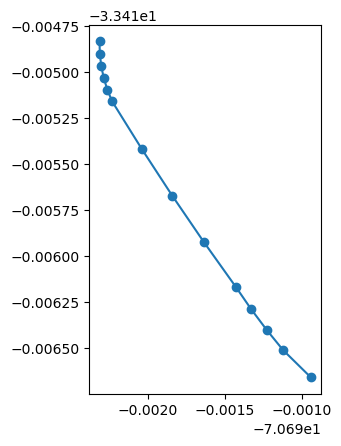

In [157]:
nodes_test = gdf_2.loc[gdf_2['pje_ep'] == gdf_2['pje_ep'].min()]
edges_test = gdf.loc[gdf['pje_ep'] == gdf['pje_ep'].min()]

fig,ax = plt.subplots(1,1)

nodes_test.plot(ax=ax)
edges_test.plot(ax=ax)